In [1]:
!pip install --upgrade -q tensorflow tensorflow-io

In [3]:
import os
import cv2
import glob
import timeit
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from keras import layers, models
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

In [5]:
dataset = Path(r"/kaggle/input/") 
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset" 

In [6]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 292667.27it/s]


In [7]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [8]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

Train samples: 13545
Validation samples: 3387
Test samples: 4233


In [9]:
BATCH_SIZE = 16

def image_generator(img_paths, img_labels, batch_s):
    """
    Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_s (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)
    while True:
        for offset in range(0, num_samples, batch_s):
            batch_paths = img_paths[offset:offset + batch_s]
            batch_labels = img_labels[offset:offset + batch_s]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(img_path)
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0 
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [10]:
train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [11]:
class NegativeImageLayer(layers.Layer):
    """
    Custom layer that converts an image into its negative representation.

    This layer takes an input image tensor and performs element-wise negation
     to obtain the negative representation of the image.
    """

    def __init__(self):
        """
        Initializes the NegativeImageLayer.
        """
        super(NegativeImageLayer, self).__init__()

    def build(self, input_shape):
        """
        Builds the NegativeImageLayer.

        This method is called when the layer is connected to the model and creates the layer's weights if necessary.

        Args:
            input_shape (tuple or tf.TensorShape): Shape of the input tensor.

        Returns:
            None
        """
        super(NegativeImageLayer, self).build(input_shape)

    @staticmethod
    def call(self, **kwargs):
        """
        Performs element-wise negation of the input tensor to obtain the negative representation.

        Args:
            self (tf.Tensor): Input tensor representing the image.

        Returns:
            tf.Tensor: Negative representation of the input image tensor.
        """
        return tf.negative(self)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the layer.

        Args:
            input_shape (tuple or tf.TensorShape): Shape of the input tensor.

        Returns:
            tf.TensorShape: Output shape of the layer.
        """
        return super(NegativeImageLayer, self).compute_output_shape(input_shape)

In [12]:
class TwiceMaxMinPooling2D(layers.Layer):
    """
    Custom layer that performs twice max-min pooling on a 2D input tensor.
    """

    def __init__(self, pool_size=(2, 2), strides=2, factor=1.0, padding="SAME", **kwargs):
        """
        Initialize the TwiceMaxMinPooling2D layer.

        Args:
            pool_size (tuple): Size of the pooling window (default: (2, 2)).
            strides (int): Stride size for the pooling window (default: 2).
            factor (float): Scaling factor (not used in current implementation) (default: 1.0).
            padding (str): Padding mode for the input tensor (default: "SAME").
            **kwargs: Additional keyword arguments passed to the base class constructor.
        """
        super(TwiceMaxMinPooling2D, self).__init__(**kwargs)

        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        self.factor = tf.constant(factor)

    def get_config(self):
        """
        Get the configuration of the TwiceMaxMinPooling2D layer.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding
        })
        return config

    def call(self, inputs, *args, **kwargs):
        """
        Perform the computation for the TwiceMaxMinPooling2D layer.

        Args:
            inputs (tf.Tensor): Input tensor.
            *args: Additional positional arguments.
            **kwargs: Additional keyword arguments.

        Returns:
            tf.Tensor: Output tensor.
        """
        batch, height, width, channel = inputs.shape

        patch = tf.image.extract_patches(inputs,
                                         sizes=[1, self.pool_size[0], self.pool_size[1], 1],
                                         strides=[1, self.strides, self.strides, 1],
                                         rates=[1, 1, 1, 1],
                                         padding=self.padding)

        out_shape = tf.shape(patch)
        out_batch = out_shape[0]
        out_height = out_shape[1]
        out_width = out_shape[2]
        out_channel = out_shape[3]

        patch = tf.reshape(patch, (out_batch, out_height, out_width, self.pool_size[0] * self.pool_size[1], channel))

        max_values = tf.math.reduce_max(patch, axis=3)
        min_values = tf.math.reduce_min(patch, axis=3)
        pooled_output = 2 * max_values - min_values

        output = tf.cast(pooled_output, tf.float32)

        return output

In [13]:
def create_metrics():
    """
    Creates instances of the 'Recall' and 'Precision' metrics and defines a custom function 'f1_score'
    to measure the model's performance.

    Returns:
    tuple: A tuple of the 'Recall' and 'Precision' metrics, and the 'F1' score function.
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score of a model's performance given true and predicted labels.

        Parameters:
        y_true (tensor): The true labels.
        y_pred (tensor): The predicted labels.

        Returns:
        float: The F1 score.
        """
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_true * y_pred, 0, 1
                )
            )
        )

        possible_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_true, 0, 1
                )
            )
        )

        predicted_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_pred, 0, 1
                )
            )
        )

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        return f1_val

    recall_metric = tf.keras.metrics.Recall()
    precision_metric = tf.keras.metrics.Precision()
    f1_score_metric = f1_score

    return recall_metric, precision_metric, f1_score_metric

In [14]:
inputs = layers.Input(shape=(224, 224, 3), name="Input")

# Block 1
x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = layers.BatchNormalization()(x)
blk1 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

# Block 2
x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = layers.BatchNormalization()(x)
blk2 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

# Block 3
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same", name="MaxPool3")(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = layers.BatchNormalization()(x)
blk3 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(x)

# Block 4
x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool5")(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = layers.BatchNormalization()(x)

# Block 5
y = NegativeImageLayer()(blk2)
y = TwiceMaxMinPooling2D(pool_size=(3, 3))(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv7")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool7")(y)
y = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv5")(y)
y = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv8")(y) 
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool8")(y)
y = layers.Conv2D(224, kernel_size=(3, 3), padding="same", activation="relu", name="Conv9")(y)
blk5 = layers.BatchNormalization()(y)


x = layers.Concatenate(name="DirectConcat")([blk4, blk5])

x = layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = layers.Dense(4, activation="softmax", name="Output")(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', create_metrics()])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 32  896         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 DConv1 (DepthwiseConv2D)       (None, 224, 224, 64  640         ['Conv1[0][0]']                  
                                )                                                             

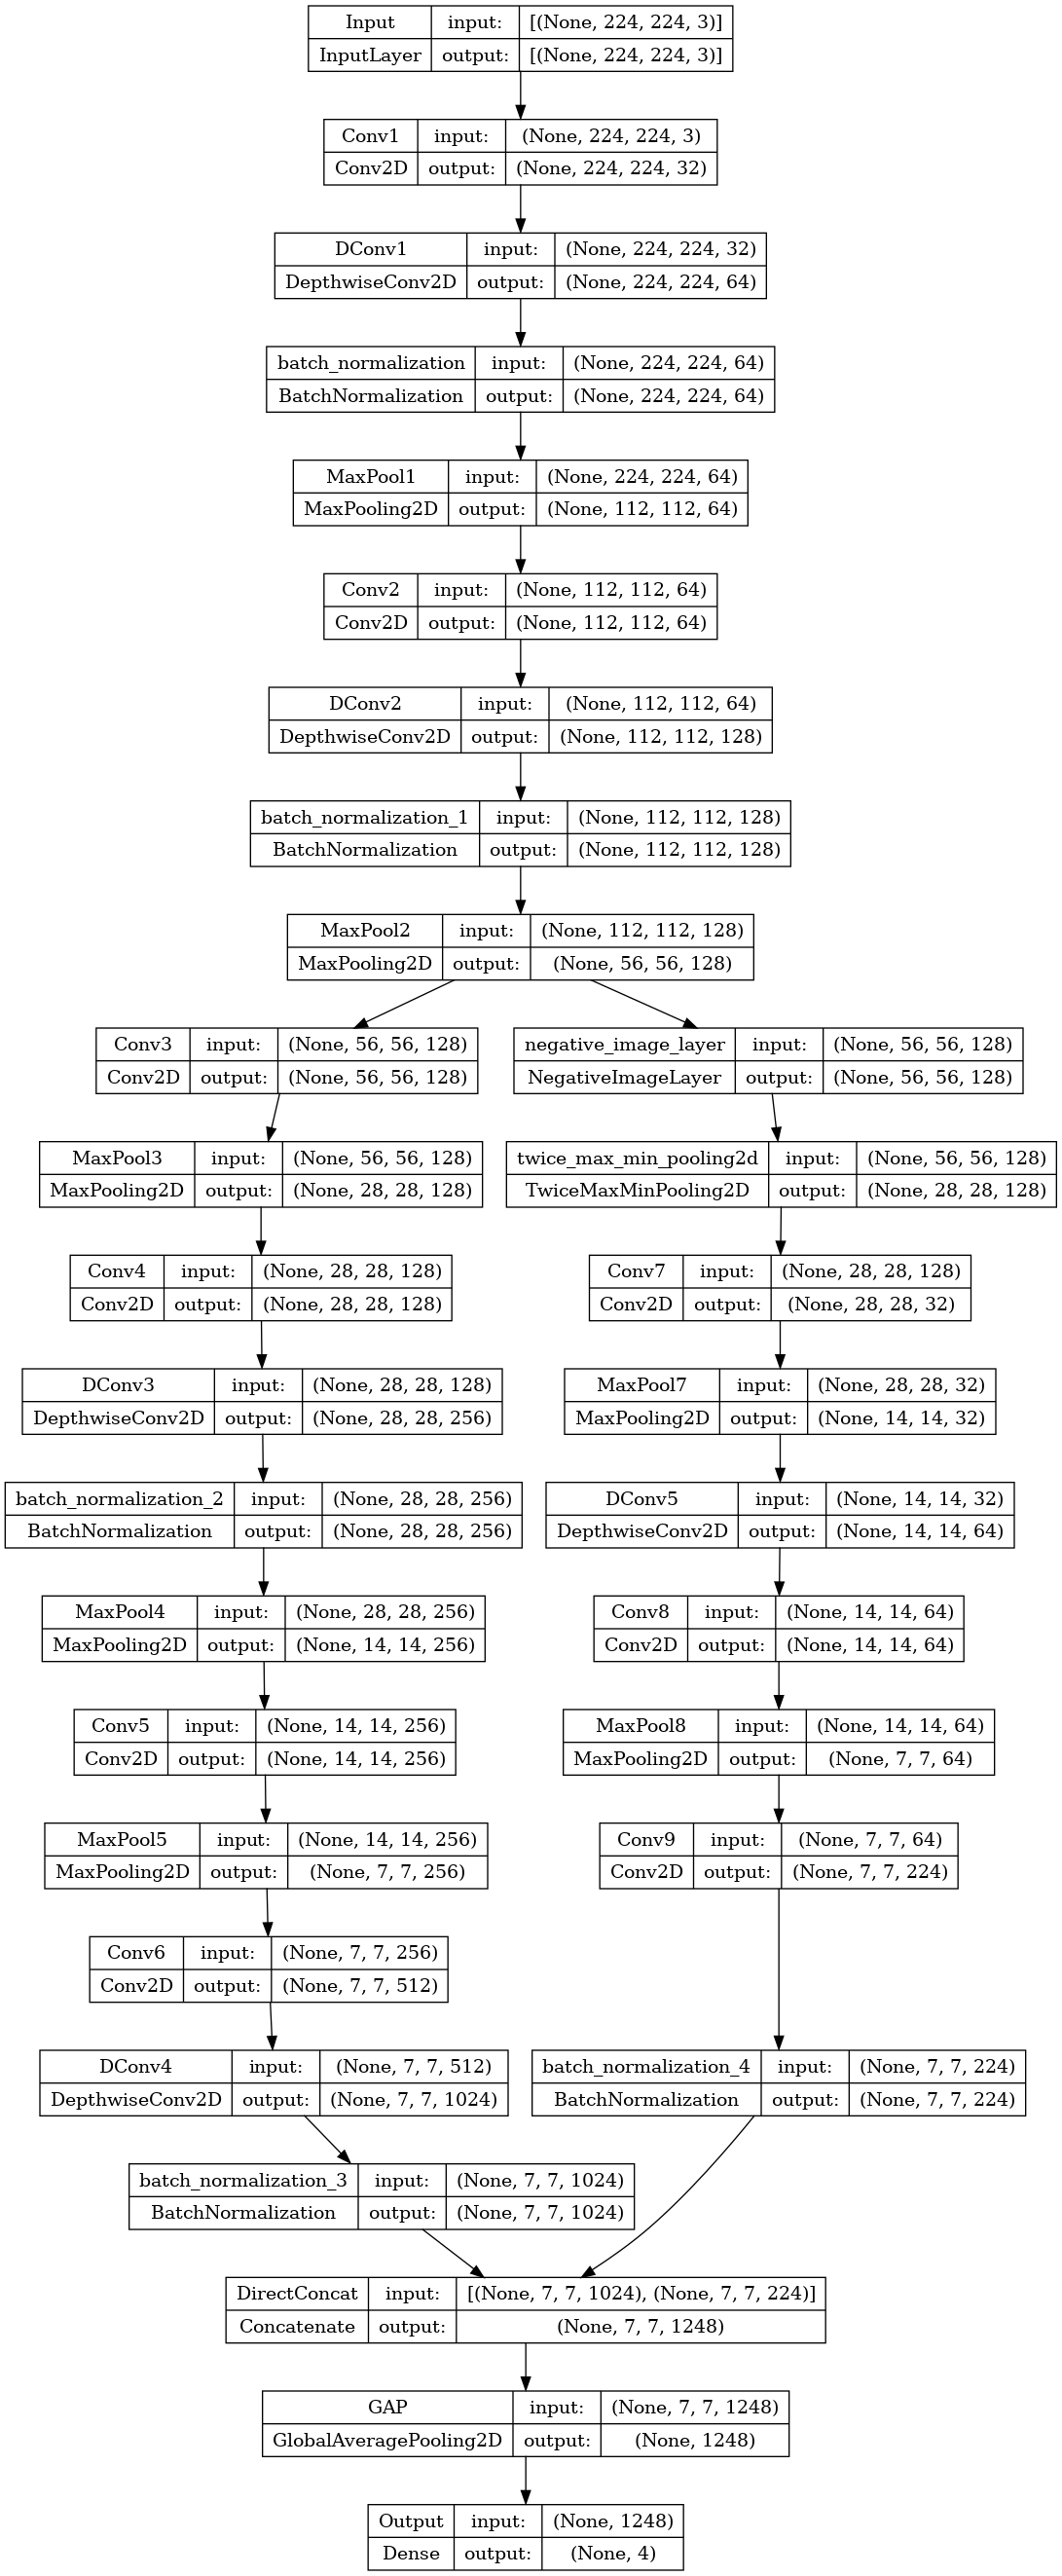

In [17]:
plot_model(model, show_shapes=True)

In [18]:
TOTAL_EPOCHS = 25
INITIAL_LEARNING_RATE = 0.75e-4
DECAY_RATE = 0.96

def learning_rate_scheduler(epoch, current_learning_rate):
    """
    A function that returns the learning rate for each epoch.

    Args:
        epoch (int): The current epoch.
        current_learning_rate (float): The current learning rate.

    Returns:
        float: The new learning rate.
    """
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = INITIAL_LEARNING_RATE
    else:
        new_learning_rate = current_learning_rate * DECAY_RATE

    return new_learning_rate

In [19]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [20]:
LOG_DIR = "logs/"
checkpoint_path = os.path.join(LOG_DIR, "weights-{epoch:02d}.ckpt")
checkpoint_callback = ModelCheckpoint(checkpoint_path,save_weights_only=True)

In [21]:
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
os.makedirs(LOG_DIR, exist_ok=True)

In [22]:
model_structure_path = os.path.join(LOG_DIR, "model_structure.json")
with open(model_structure_path, "w") as f:
    f.write(model.to_json())

In [23]:
start_time = timeit.default_timer()

history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[learning_rate_callback, checkpoint_callback, tensorboard_callback]
)

end_time = timeit.default_timer()
execution_time = end_time - start_time

Epoch 1/25
846/846 [==============================] - 206s 224ms/step - loss: 0.5944 - accuracy: 0.7952 - recall: 0.7143 - precision: 0.8556 - f1_score: 0.7645 - val_loss: 0.6816 - val_accuracy: 0.6872 - val_recall: 0.6360 - val_precision: 0.7079 - val_f1_score: 0.6680 - lr: 7.5000e-05
Epoch 2/25
846/846 [==============================] - 78s 91ms/step - loss: 0.3058 - accuracy: 0.8907 - recall: 0.8763 - precision: 0.9033 - f1_score: 0.8891 - val_loss: 0.5244 - val_accuracy: 0.7701 - val_recall: 0.7438 - val_precision: 0.7916 - val_f1_score: 0.7661 - lr: 7.5000e-05
Epoch 3/25
846/846 [==============================] - 86s 101ms/step - loss: 0.2269 - accuracy: 0.9199 - recall: 0.9132 - precision: 0.9273 - f1_score: 0.9200 - val_loss: 0.6773 - val_accuracy: 0.7225 - val_recall: 0.6952 - val_precision: 0.7397 - val_f1_score: 0.7162 - lr: 7.5000e-05
Epoch 4/25
846/846 [==============================] - 84s 99ms/step - loss: 0.1749 - accuracy: 0.9401 - recall: 0.9358 - precision: 0.9437 - f

In [24]:
print("Execution time:", execution_time, "seconds")

Execution time: 2131.096898781 seconds


In [25]:
model.save(os.path.join(LOG_DIR, "final_model.h5"))

In [26]:
def zip_directory(output_zip_filename, directory_path,):
    """
    Zips a directory.

    Args:
        output_zip_path (str): Output path for the resulting ZIP file.
        directory_path (str): Path to the directory to be zipped.
    """
    shutil.make_archive(output_zip_filename, 'zip', directory_path)

directory_path = '/kaggle/working/logs'
output_zip_filename = 'logs'
output_zip_path = '/kaggle/working/logs.zip'

zip_directory(output_zip_filename, directory_path)

In [27]:
_ = model.evaluate(test_generator, steps=test_steps)

264/264 [==============================] - 40s 151ms/step - loss: 0.4400 - accuracy: 0.9304 - recall: 0.9304 - precision: 0.9304 - f1_score: 0.9304


In [34]:
def plot_metrics(hist, metric_name_list, y_lim=None, fig_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        y_lim: a tuple (min, max) specifying the limits of the y-axis (optional)
        fig_size: a tuple (width, height) specifying the figure size (optional)

    Returns:
        None
    """
    num_metrics = len(metric_name_list)
    f, axes = plt.subplots(num_metrics, figsize=(fig_size[0], fig_size[1] * num_metrics))

    for index, metric_name in enumerate(metric_name_list):
        metric = hist.history[metric_name]
        val_metric = hist.history[f"val_{metric_name}"]
        rng = range(1, len(metric) + 1)

        axes[index].plot(rng, metric, label=metric_name)
        axes[index].plot(rng, val_metric, label=f"val_{metric_name}")
        axes[index].legend()
        axes[index].set_xlabel("Epochs")
        axes[index].set_ylabel(metric_name.capitalize())
        axes[index].set_title(f"{metric_name.capitalize()} vs Epochs")

        if metric_name == "loss" and y_lim is not None:
            axes[index].set_ylim(0, 4)
        elif y_lim is not None:
            axes[index].set_ylim(0, 1)

        axes[index].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

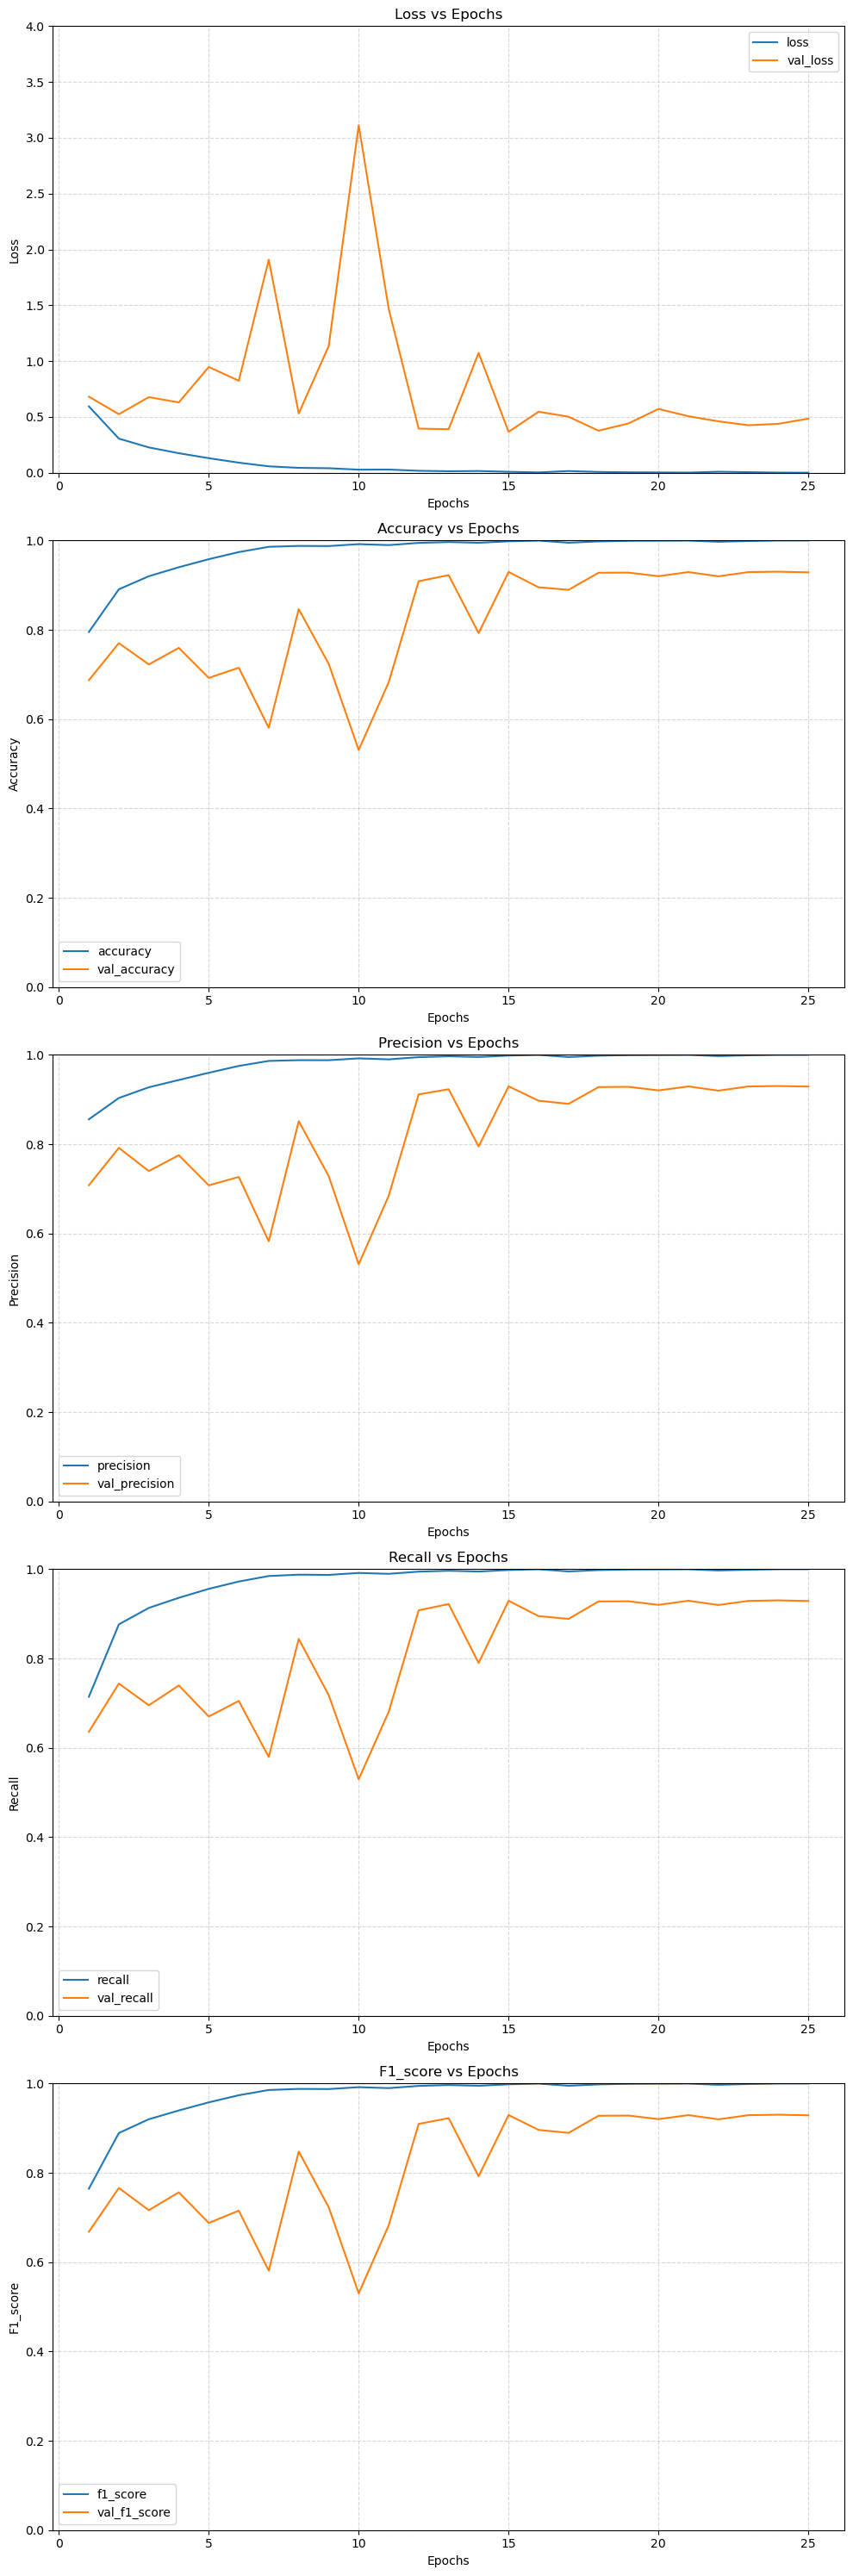

In [35]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score"]
plot_metrics(history, metric_names, y_lim=(0, 1))

In [30]:
def generate_model_performance(m, t_gen, t_steps, b_size):
    """
    Generates model performance on each class separately in the dataset.

    Parameters:
        m (tensorflow.keras.models.Model): The trained model.
        t_gen: The generator object for test data.
        t_steps (int): Number of steps for the test data.
        b_size (int): Batch size used for predictions.

    Returns:
        Tuple: A tuple containing true labels and predicted labels.
    """
    y_true = []
    y_pred = []

    preds = m.predict(t_gen, steps=t_steps)

    for i in range(t_steps):
        _, l = next(t_gen)
        y_true.extend(np.argmax(l, axis=1))
        y_pred.extend(np.argmax(preds[i * b_size: (i + 1) * b_size], axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cls = label_encoder.classes_
    errors = np.sum(y_pred != y_true)
    tests = len(y_pred)
    accuracy = (1 - errors / tests) * 100

    classification_report_str = classification_report(
        y_true,
        y_pred,
        target_names=cls,
        digits=4,
        zero_division=1
    )

    print(classification_report_str)
    print(f'There were {errors} errors in {tests} tests for an accuracy of {accuracy:6.2f}')

    return y_true, y_pred

In [31]:
true_labels, predicted_labels = generate_model_performance(model, test_generator, test_steps, BATCH_SIZE)

264/264 [==============================] - 16s 61ms/step
                 precision    recall  f1-score   support

          COVID     0.9764    0.9553    0.9657       693
   Lung_Opacity     0.9372    0.8528    0.8930      1189
         Normal     0.9083    0.9654    0.9359      2051
Viral Pneumonia     0.9648    0.9416    0.9530       291

       accuracy                         0.9304      4224
      macro avg     0.9467    0.9288    0.9369      4224
   weighted avg     0.9315    0.9304    0.9299      4224

There were 294 errors in 4224 tests for an accuracy of  93.04


In [32]:
cm = confusion_matrix(true_labels, predicted_labels)

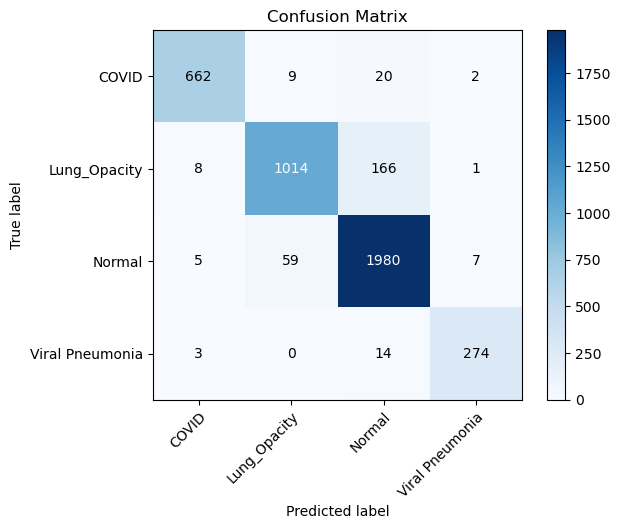

In [33]:
fig, ax = plt.subplots()

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes,
    yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

text_colors = np.where(cm > np.max(cm) / 2., "white", "black")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color=text_colors[i, j])

plt.show()